07/06/2020

heatmaps/dotplots showing common gene info (#s match sections)

In [1]:
library(tidyverse)
library(pheatmap)
library(RColorBrewer)
save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
save_dir = '../data/processed/fig4_modelling/common_genes/'


# 1. common genes tissue specific enrichment

In [3]:
stats_tfall_df = read.csv(paste0(save_dir,'stats_fisher_all_tfs.csv'))
stats_tfall_df_filt = filter(stats_tfall_df,pval_bonf<0.05)
dim(stats_tfall_df)[1]
dim(stats_tfall_df_filt)[1]
head(stats_tfall_df)

[1] 7935

[1] 1486

,X,tf,tissue,jaccard,intersect_over_min,intersection,union,num_in_1,num_in_2,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf
,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,AHR,Airway,0.0002521369,0.02767017,50,198305,196548,1807,50,49.31833,1.0339097,4.267378e-01,1.000000e+00,0.00000
2,1,ARID5B,Airway,0.0145876675,0.03616362,4691,321573,196548,129716,4691,3540.32992,1.3457268,6.598914e-80,4.752159e-73,72.32311
3,2,ARNT,Airway,0.0010870843,0.02813688,222,204216,196548,7890,222,215.34123,1.0363609,3.088364e-01,1.000000e+00,0.00000
4,3,ARNTL,Airway,0.0006195081,0.02336449,125,201773,196548,5350,125,146.01718,0.8591779,9.603617e-01,1.000000e+00,0.00000
5,4,ATF1,Airway,0.0006121413,0.02727878,123,200934,196548,4509,123,123.06383,1.0073575,4.804018e-01,1.000000e+00,0.00000
6,5,ATF2,Airway,0.0035076860,0.02877857,782,222939,196548,27173,782,741.63083,1.0575752,6.492213e-02,1.000000e+00,0.00000


In [4]:
summary(stats_tfall_df_filt$oddsratio)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    1.04     1.38     1.69   402.70     3.05 91598.89 

because odds ratios are super skewed remove super outlier odds ratios (as these are super small numbers)

In [5]:
max_odds_ratio = 10
stats_tfall_df_filt = filter(stats_tfall_df_filt, oddsratio<max_odds_ratio)
dim(stats_tfall_df_filt)[1]

[1] 1329

In [6]:
length(unique(stats_tfall_df$tf))
length(unique(stats_tfall_df_filt$tf))


[1] 529

[1] 348

348 tfs have at least 1 tissue that it is significant in

Saving 7 x 7 in image



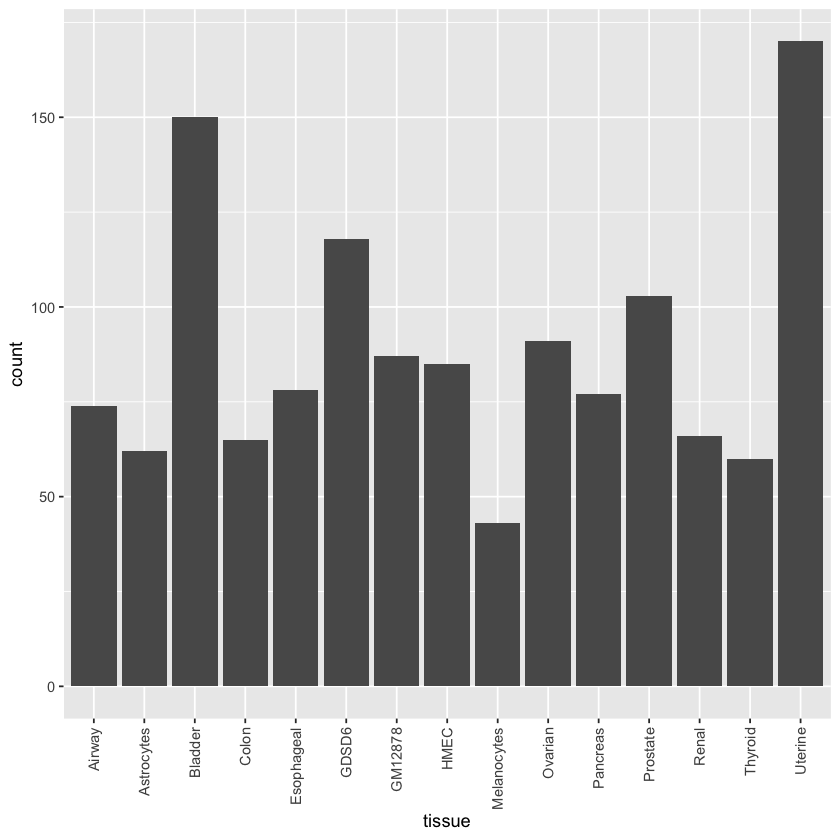

In [7]:
tissue_num = stats_tfall_df_filt%>%
    group_by(tissue)%>%
    summarise(count=n())
ggplot(tissue_num,aes(x=tissue,y=count))+
    geom_bar(stat='identity')+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggsave(paste0(save_dir, 'bar_tissue_num_tf_sig.pdf'))

# of tfs per tissue that are sig for common genes

Saving 7 x 7 in image



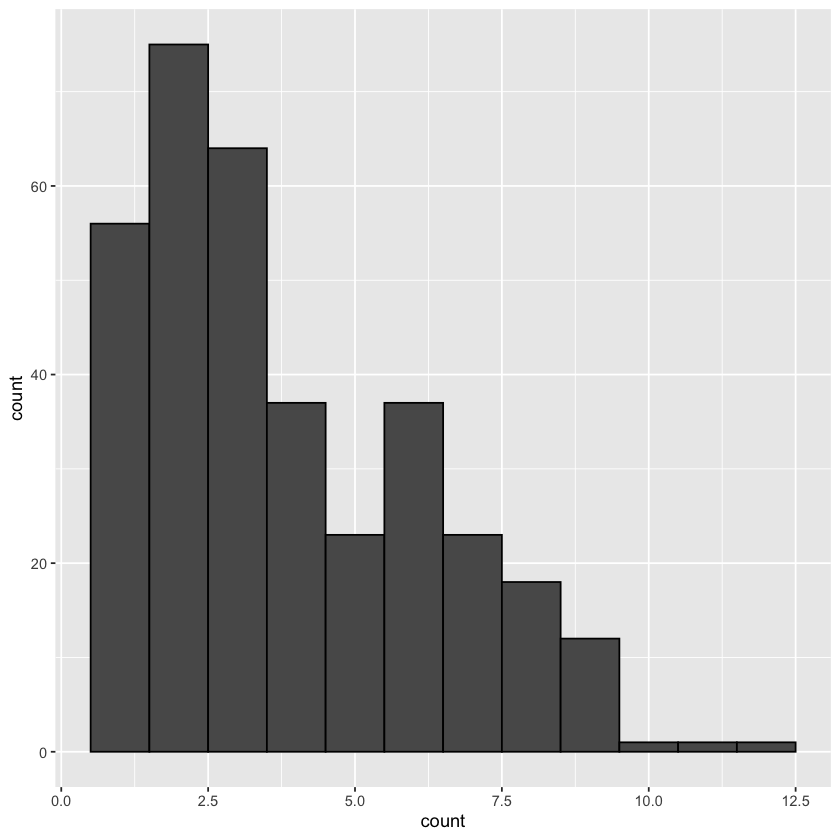

In [8]:
tf_num_tissue_sig = stats_tfall_df_filt%>%
    group_by(tf)%>%
    summarise(count=n())
ggplot(tf_num_tissue_sig,aes(x=count))+
    geom_histogram(binwidth=1, colour="black",)
ggsave(paste0(save_dir, 'hist_tf_num_tissue_sig.pdf'))

histogram for # tissues the tfs (n=348) are significantly enriched in for common genes 

# make heatmaps for ordering then dotplots for viewing fisher exact results

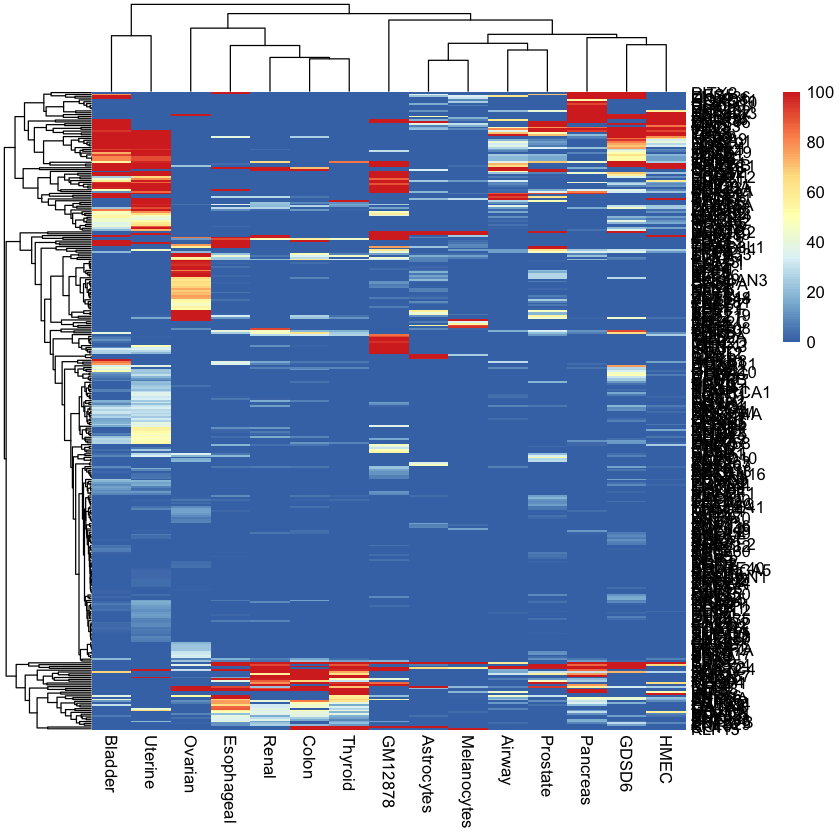

In [75]:
## FIX 
stats_tfall_df_filt_wide = stats_tfall_df_filt%>%
    pivot_wider(id_cols = tf, names_from = tissue, values_from = log_pval_bonf)%>%
    column_to_rownames("tf")
stats_tfall_df_filt_wide[is.na(stats_tfall_df_filt_wide)] = 0
p = pheatmap(stats_tfall_df_filt_wide)


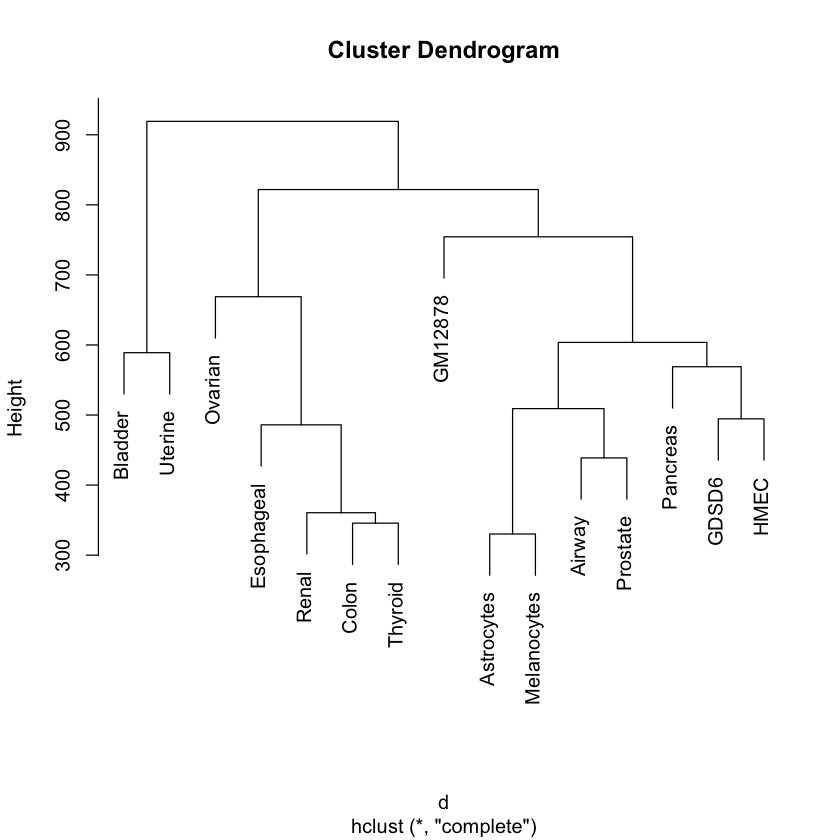

In [76]:
par(bg='white')
plot(p$tree_col)

In [43]:
tf_ordering = rownames(stats_tfall_df_filt_wide)[p$tree_row[["order"]]]
tissue_ordering = colnames(stats_tfall_df_filt_wide)[p$tree_col[["order"]]]

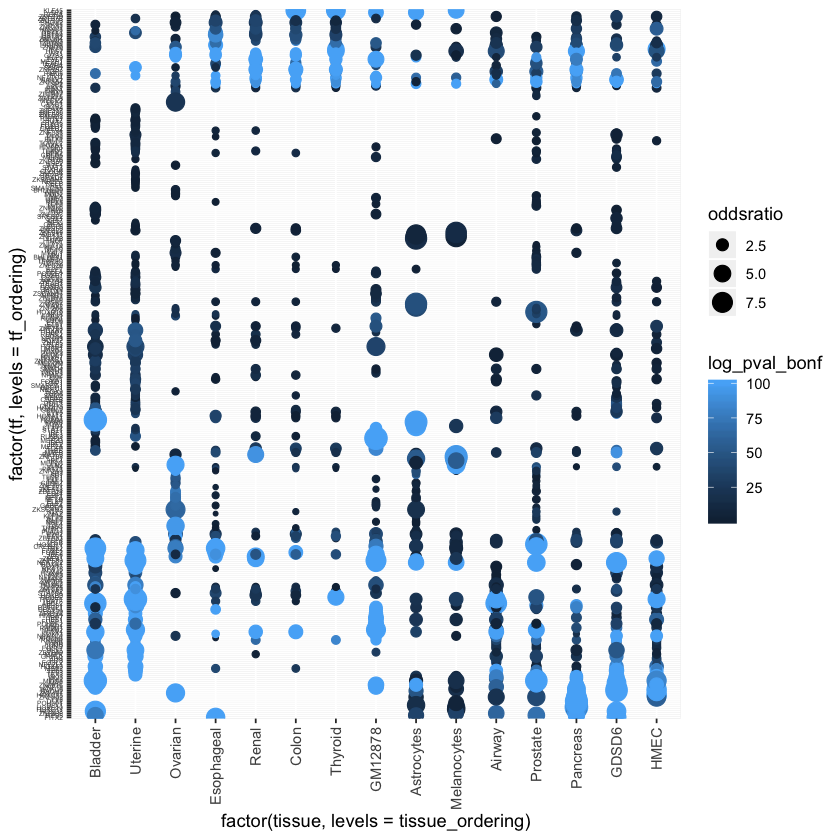

In [44]:
ggplot(stats_tfall_df_filt, aes(x=factor(tissue,levels=tissue_ordering), y=factor(tf,levels=tf_ordering), color=log_pval_bonf,size=oddsratio))+geom_point()+ 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
        axis.text.y = element_text(size = 4, angle = 0)  )
ggsave(paste0(save_dir, 'all_tissue_tf_stats_fisher.pdf'),width=8, height=20)

pdf 
  2

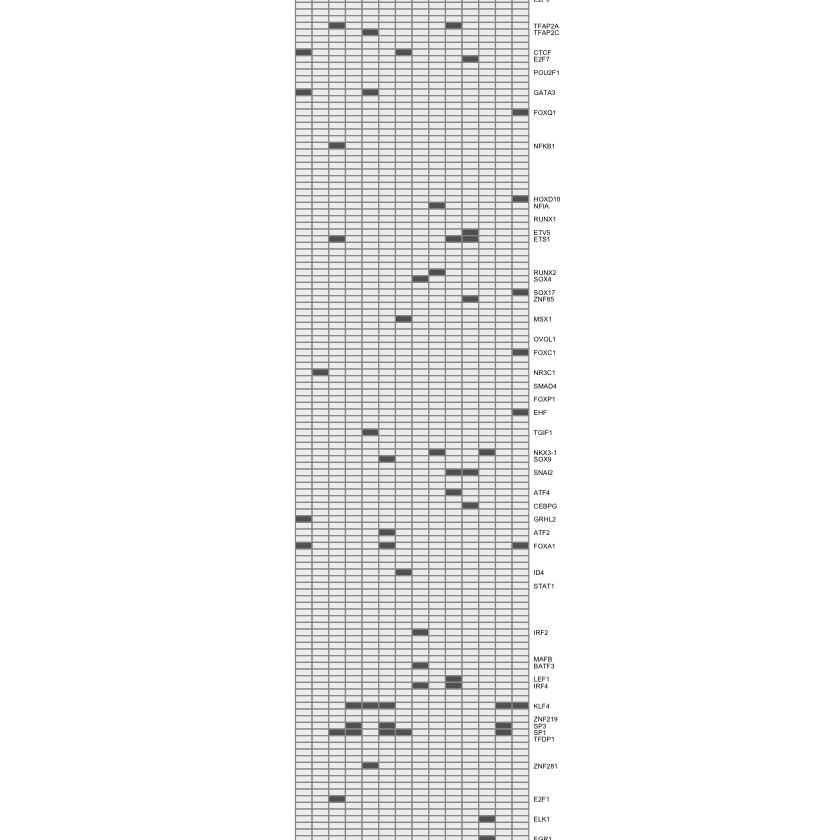

In [12]:
tf_annon_df = read.csv('../data/external/transcription_factor_info_063020.csv')#,stringsAsFactors=F)
tf_annon_df$exists=1.0
tf_annon_df_wide = tf_annon_df%>%
    distinct()%>%
    pivot_wider(id_cols =tf,names_from=cell_type, values_from=exists)%>%
    filter(tf %in% tf_ordering)%>%
    column_to_rownames("tf")
tf_annon_df_wide[is.na(tf_annon_df_wide)]=0
tissue_ordering_sel = tissue_ordering[tissue_ordering %in% colnames(tf_annon_df_wide)]
tf_names_df = data.frame(tf_orig=as.character(rev(tf_ordering)),
                           tf_new=ifelse(as.character(rev(tf_ordering)) %in% rownames(tf_annon_df_wide),as.character(rev(tf_ordering)),"")
)
tf_annon_df_wide = tf_annon_df_wide[rev(tf_ordering),tissue_ordering_sel]
tf_annon_df_wide[is.na(tf_annon_df_wide)] = 0
p_tf_annon = pheatmap(tf_annon_df_wide,
         cluster_rows=F,cluster_cols=F,
        labels_row = tf_names_df$tf_new,
                      legend =F,
                      cellheight=4, cellwidth = 10,
                      fontsize_row=4,
        color = colorRampPalette(brewer.pal(n =3, name ="Greys"))(255))

save_pheatmap_pdf(p_tf_annon,paste0(save_dir,'all_tissue_tf_stats_fisher_tf_annon_side.pdf'), width=5, height=22) 


to do make it clustered by tf

# now look at  only krt tfs (slice rows)

In [51]:
KRT_tfs =c('ATF1', 'ATF2', 'ATF3', 'ATF4', 'ATF5', 'BARX2', 'CEBPA', 'CEBPG', 
           'DLX3', 'DLX5', 'E2F1', 'E2F3', 'E2F4', 'E2F7', 'ELF5', 'ESRRA', 'ETS1', 'ETV4', 
           'FOS', 'FOSL1', 'FOSL2', 'FOXF2', 'FOXK2', 'FOXP1', 'GRHL1', 'GRHL2', 'HES1', 'HES2', 'HOMEZ', 'HOXA1', 'HOXC11', 'HOXC13',
           'ID3', 'IRX2', 'IRX4', 'JUN', 'JUNB', 'JUND', 'KER2', 'KLF16', 'KLF4', 'KLF5', 'LDB2', 'MAF', 'MAFB', 'MAML3', 'NR3C1', 
           'OTX1', 'OVOL1', 'PBX1', 'PBX2', 
           'POU1F1', 'POU2F1', 'POU2F2', 'POU2F3', 'POU3F1', 'POU3F2', 'POU3F3', 'POU3F4', 'POU4F1', 'POU4F2', 'POU4F3', 'POU5F1', 'POU5F1B', 'POU6F1', 'POU6F2', 
           'PRDM1', 'PRRX1', 'RARG', 'RELB', 'RORA', 'RUNX1', 'SMAD4', 'SOX11', 'SOX15', 'SOX6', 'SOX7', 'SOX9', 'SP1', 'SP3', 'STAT1', 'STAT6', 
           'TCF4', 'TCF7L2', 'TFAP2A', 'TFAP2B', 'TFAP2C', 'TFAP2D', 'TFDP1', 'TP63', 'TWIST2', 'VDR', 'VGLL1', 'XBP1', 'ZBTB7B', 'ZEB1', 'ZNF219')


In [52]:
stats_tfall_df_filt_KRT = filter(stats_tfall_df_filt, tf %in% KRT_tfs)
dim(stats_tfall_df_filt)[1]
dim(stats_tfall_df_filt_KRT)[1]

[1] 1329

[1] 273

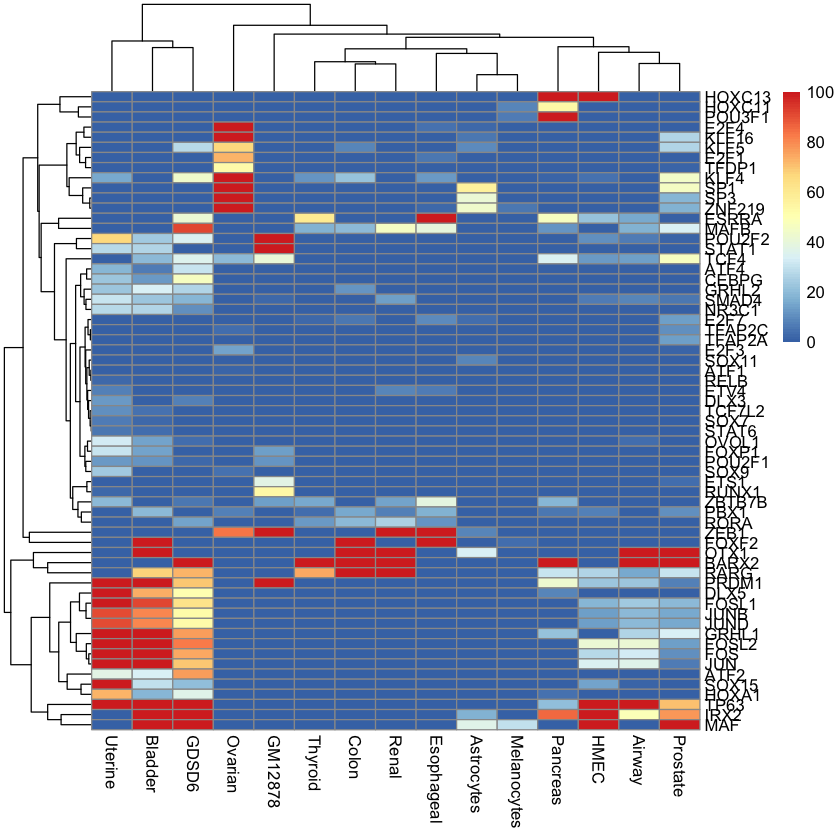

In [53]:
## FIX 
stats_tfall_df_filt_KRT_wide = stats_tfall_df_filt_KRT%>%
    pivot_wider(id_cols = tf, names_from = tissue, values_from = log_pval_bonf)%>%
    column_to_rownames("tf")
stats_tfall_df_filt_KRT_wide[is.na(stats_tfall_df_filt_KRT_wide)] = 0
p_KRT = pheatmap(stats_tfall_df_filt_KRT_wide)


In [58]:
tf_ordering_KRT = rownames(stats_tfall_df_filt_KRT_wide)[p_KRT$tree_row[["order"]]]
tissue_ordering_KRT = colnames(stats_tfall_df_filt_KRT_wide)[p_KRT$tree_col[["order"]]]

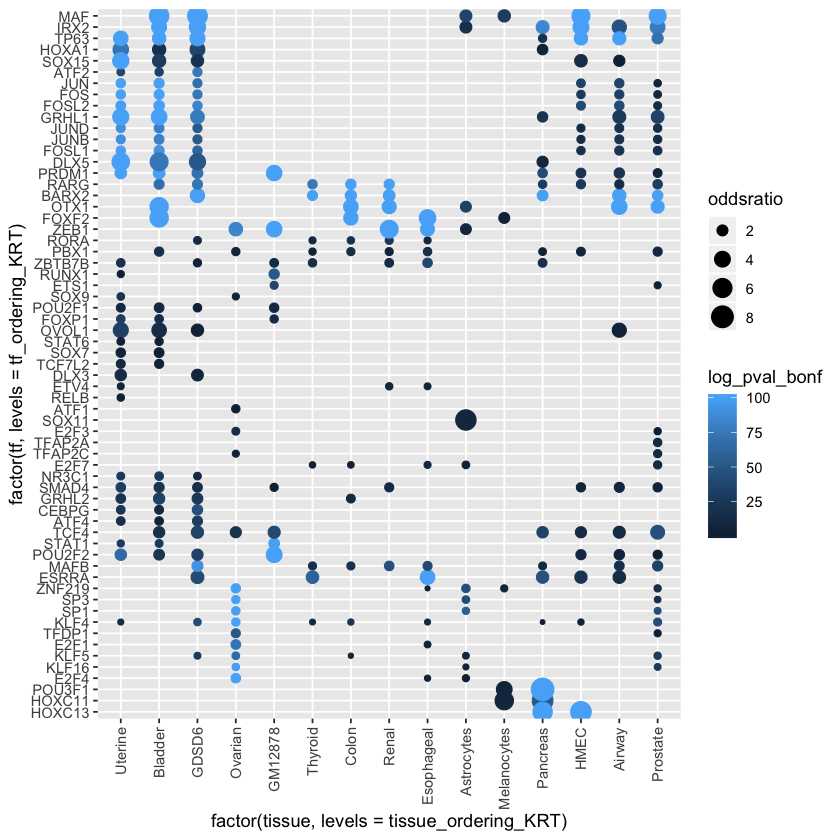

In [72]:
p = ggplot(stats_tfall_df_filt_KRT,aes(x=factor(tissue,levels=tissue_ordering_KRT), y=factor(tf,levels=tf_ordering_KRT), color=log_pval_bonf,size=oddsratio))+
    geom_point()+ 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p
ggsave(paste0(save_dir, 'KRT_tf_stats_fisher.pdf'),width=8, height=10)

# same heatmaps for KRT genes instead of common genes

In [60]:
stats_tfall_df_KRT = read.csv(paste0(save_dir,'stats_fisher_KRT_tfs.csv'))
stats_tfall_df_KRT_filt = filter(stats_tfall_df_KRT,pval_bonf<0.05)
stats_tfall_df_KRT_filt = filter(stats_tfall_df_KRT_filt, intersection>1)
stats_tfall_df_KRT_filt = mutate(stats_tfall_df_KRT_filt, logsoddsratio = log10(oddsratio))
# stats_tfall_df_KRT_filt = filter(stats_tfall_df_KRT_filt, oddsratio<100)

dim(stats_tfall_df_KRT)[1]
dim(stats_tfall_df_KRT_filt)[1]
head(stats_tfall_df_KRT_filt)

[1] 7935

[1] 507

,X,tf,tissue,jaccard,intersect_over_min,intersection,union,num_in_1,num_in_2,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf,logsoddsratio
,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,ARID5B,Airway,0.0167986351,0.03689115,384,22859,12834,10409,384,264.3967581,1.487777,6.182862e-13,3.123953e-07,6.505295,0.1725379
2,11,BARX2,Airway,0.0197072393,0.06825804,346,17557,12834,5069,346,128.7565729,2.868456,1.008730e-59,5.096708e-54,53.292710,0.4576482
3,157,NFATC4,Airway,0.0140067912,0.05939830,231,16492,12834,3889,231,98.7836480,2.458787,1.543269e-31,7.797522e-26,25.108043,0.3907208
4,168,NKX2-1,Airway,0.0005452138,0.58333333,7,12839,12834,12,7,0.3048094,51.181998,4.534037e-10,2.290868e-04,3.640000,1.7091172
5,170,NR1D1,Airway,0.0020258688,1.00000000,26,12834,12834,26,26,0.6604204,1037.983371,2.277368e-42,1.150663e-36,35.939052,3.0161904
6,224,SOX13,Airway,0.0165282527,0.03345419,406,24564,12834,12136,406,308.2639116,1.341821,2.090744e-08,1.056369e-02,1.976184,0.1276946


In [61]:
length(unique(stats_tfall_df_KRT$tf))
length(unique(stats_tfall_df_KRT_filt$tf))


[1] 529

[1] 251

number of tfs per tissue that are significantly enriched for KRT genes

Saving 7 x 7 in image



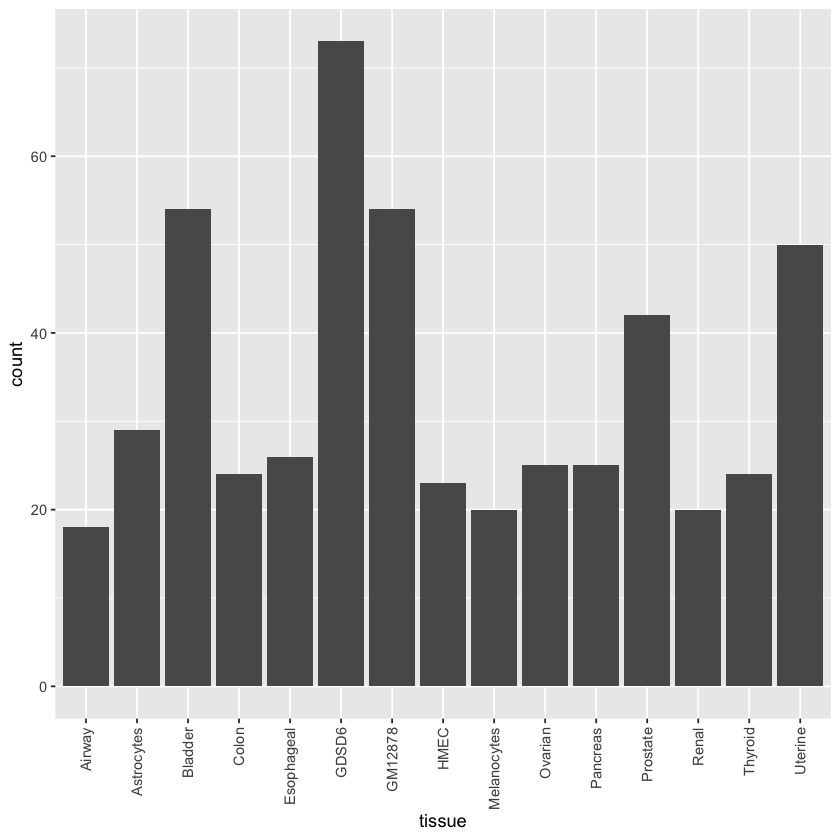

In [62]:
tissue_num_KRT = stats_tfall_df_KRT_filt%>%
    group_by(tissue)%>%
    summarise(count=n())
ggplot(tissue_num_KRT,aes(x=tissue,y=count))+
    geom_bar(stat='identity')+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggsave(paste0(save_dir, 'bar_tissue_num_tf_sig_KRT.pdf'))
    #binwidth=1, colour="black",)
# ggsave(paste0(save_dir, 'tf_num_tissue_sig.pdf'))

all tfs

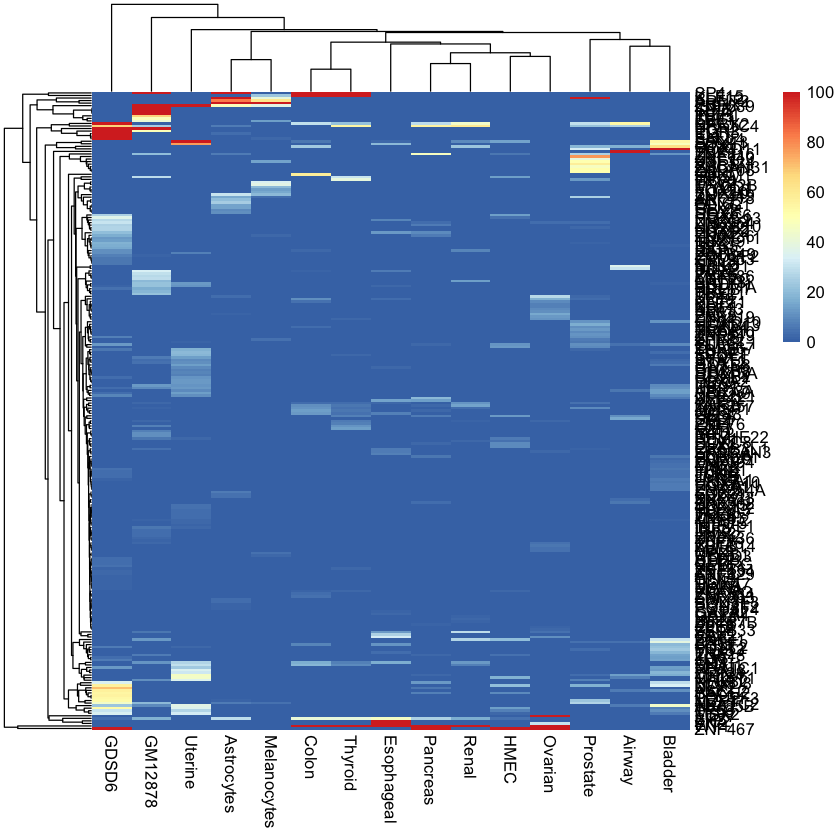

In [63]:
## FIX 
stats_tfall_df_KRT_filt_wide = stats_tfall_df_KRT_filt%>%
    pivot_wider(id_cols = tf, names_from = tissue, values_from = log_pval_bonf)%>%
    column_to_rownames("tf")
stats_tfall_df_KRT_filt_wide[is.na(stats_tfall_df_KRT_filt_wide)] = 0
p = pheatmap(stats_tfall_df_KRT_filt_wide)

tf_ordering = rownames(stats_tfall_df_KRT_filt_wide)[p$tree_row[["order"]]]
tissue_ordering = colnames(stats_tfall_df_KRT_filt_wide)[p$tree_col[["order"]]]

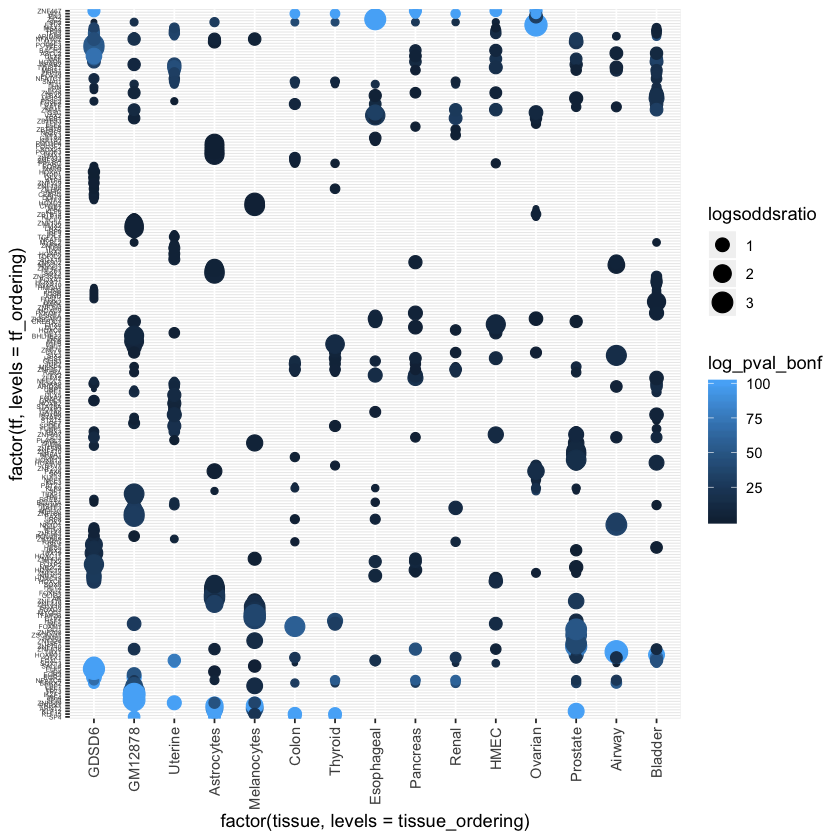

In [64]:
ggplot(stats_tfall_df_KRT_filt, aes(x=factor(tissue,levels=tissue_ordering), y=factor(tf,levels=tf_ordering), color=log_pval_bonf,size=logsoddsratio))+geom_point()+ 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
        axis.text.y = element_text(size = 4, angle = 0)  )
ggsave(paste0(save_dir, 'all_tissue_tf_stats_fisher_KRT.pdf'),width=8, height=20)

In [65]:
# filter for KRT Tfs specifically
stats_tfall_df_KRT_filt_KRT = filter(stats_tfall_df_KRT_filt, tf %in% KRT_tfs)
dim(stats_tfall_df_KRT_filt)[1]
dim(stats_tfall_df_KRT_filt_KRT)[1]

[1] 507

[1] 86

In [33]:
# ## FIX 
# stats_tfall_df_KRT_filt_KRT_wide = stats_tfall_df_KRT_filt_KRT%>%
#     pivot_wider(id_cols = tf, names_from = tissue, values_from = oddsratio)%>%
#     column_to_rownames("tf")
# stats_tfall_df_KRT_filt_KRT_wide[is.na(stats_tfall_df_KRT_filt_KRT_wide)] = 0
# p_KRT = pheatmap(stats_tfall_df_KRT_filt_KRT_wide)
# tf_ordering_KRT = rownames(stats_tfall_df_KRT_filt_KRT_wide)[p_KRT$tree_row[["order"]]]
# tissue_ordering_KRT = colnames(stats_tfall_df_KRT_filt_KRT_wide)[p_KRT$tree_col[["order"]]]

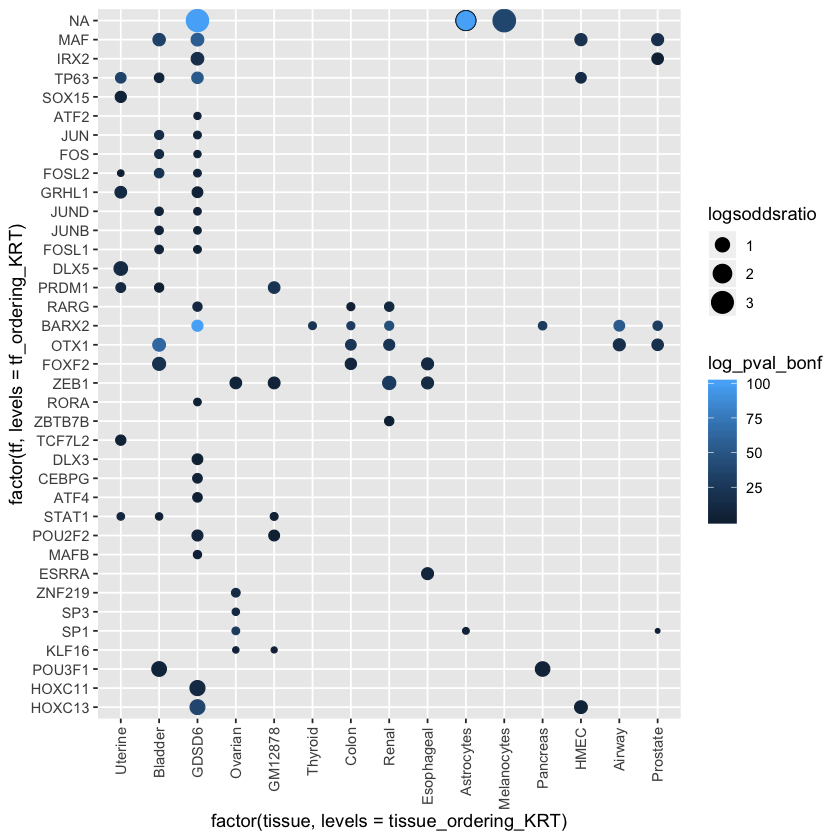

In [71]:
p = ggplot(stats_tfall_df_KRT_filt_KRT,aes(x=factor(tissue,levels=tissue_ordering_KRT), y=factor(tf,levels=tf_ordering_KRT), color=log_pval_bonf,size=logsoddsratio))+
    geom_point()+ 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p
ggsave(paste0(save_dir, 'KRTgene_KRT_tf_stats_fisher.pdf'),width=8, height=10)